# BAIS 3250 Final Project
## NBA Player Performance vs. Travel Schedule
### Evan Haines

In [155]:
# Importing required libraries
import pandas as pd
import numpy as np
import requests
import statsmodels.api as sm
import seaborn as sns
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from geopy.distance import geodesic
import time
import random
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

#### Data Aquisition

In [4]:
# Accessing NBA Stats API
# Seting headers to bypass NBA Stats API restrictions
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
    "Accept": "application/json, text/plain, */*",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.nba.com/",
    "Origin": "https://www.nba.com",
    "Connection": "keep-alive",
}

# Setting the our Season range 
seasons = ["2020-21", "2021-22", "2022-23", "2023-24"]

all_data = []

# Looping through and extracting game logs
for season in seasons:
    print(f"Fetching data for season {season}...")
    
    url = f"https://stats.nba.com/stats/playergamelogs?Season={season}&SeasonType=Regular%20Season"
    response = requests.get(url, headers=HEADERS)
    time.sleep(random.uniform(2, 4))

    data = response.json()
    columns = data["resultSets"][0]["headers"]
    rows = data["resultSets"][0]["rowSet"]
    
    df_season = pd.DataFrame(rows, columns=columns)
    all_data.append(df_season)

# Combining all seasons into one data frame
df_stats = pd.concat(all_data, ignore_index=True)
display(df_stats)

# Summary output
print(f"\n Finished scraping {len(seasons)} seasons.")
print(f" Number of unique players: {df_stats['PLAYER_ID'].nunique()}")
print(f" Total game logs recorded: {len(df_stats)}")

# Save to CSV
df_stats.to_csv("nba_player_game_logs_raw.csv", index=False)

Fetching data for season 2020-21...
Fetching data for season 2021-22...
Fetching data for season 2022-23...
Fetching data for season 2023-24...


,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC
0,2020-21,1628396,Tony Bradley,Tony,1610612760,OKC,Oklahoma City Thunder,0022001074,2021-05-16T00:00:00,OKC vs. LAC,...,1,16020,11759,4875,8778,1849,143,10341,1,14:07
1,2020-21,1629653,Devon Dotson,Devon,1610612741,CHI,Chicago Bulls,0022001068,2021-05-16T00:00:00,CHI vs. MIL,...,10833,16020,8773,2707,9641,1849,143,10341,1,21:25
2,2020-21,203210,JaMychal Green,JaMychal,1610612743,DEN,Denver Nuggets,0022001076,2021-05-16T00:00:00,DEN @ POR,...,16132,16020,8773,18135,15209,1849,143,12891,1,21:26
3,2020-21,1629750,Javonte Green,Javonte,1610612741,CHI,Chicago Bulls,0022001068,2021-05-16T00:00:00,CHI vs. MIL,...,16132,6289,13920,3055,8263,1849,143,10964,1,23:14
4,2020-21,203503,Tony Snell,Tony,1610612737,ATL,Atlanta Hawks,0022001066,2021-05-16T00:00:00,ATL vs. HOU,...,16132,16020,11759,3454,13665,1849,143,13541,1,23:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,2023-24,201142,Kevin Durant,Kevin,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,6163,1530,4872,12394,4458,1,138,4374,1,36:47
101384,2023-24,1627750,Jamal Murray,Jamal,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24T00:00:00,DEN vs. LAL,...,18879,134,3398,9396,5290,2248,138,4739,1,34:14
101385,2023-24,203994,Jusuf Nurkić,Jusuf,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,25189,6969,7525,10350,4232,1,138,4739,1,27:52
101386,2023-24,1626164,Devin Booker,Devin,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,22902,1530,628,7721,1538,2248,138,876,1,36:58



 Finished scraping 4 seasons.
 Number of unique players: 885
 Total game logs recorded: 101388


In [9]:
player_info_data = []

# Loop through unique player IDs
for player_id in df_stats['PLAYER_ID'].unique():
    url = f"https://stats.nba.com/stats/commonplayerinfo?PlayerID={player_id}"
    response = requests.get(url, headers=HEADERS)
    time.sleep(random.uniform(2, 4))  # Be nice to the API

    data = response.json()
    columns = data["resultSets"][0]["headers"]
    row = data["resultSets"][0]["rowSet"][0]
    info_dict = dict(zip(columns, row))

    birthdate = pd.to_datetime(info_dict['BIRTHDATE'])
    age = (datetime.now() - birthdate).days // 365
    position = info_dict['POSITION']

    print(f"Scraping player {player_id}")

    player_info_data.append({
        'PLAYER_ID': player_id,
        'Age': age,
        'Position': position
    })

# Convert to DataFrame
player_info_df = pd.DataFrame(player_info_data)

# Merge with df_stats
df_stats = df_stats.merge(player_info_df, on='PLAYER_ID', how='left')

display(df_stats)

Scraping player 1628396
Scraping player 1629653
Scraping player 203210
Scraping player 1629750
Scraping player 203503
Scraping player 203994
Scraping player 203085
Scraping player 1627745
Scraping player 201959
Scraping player 203081
Scraping player 1629008
Scraping player 1630202
Scraping player 204456
Scraping player 202709
Scraping player 101150
Scraping player 204001
Scraping player 1630183
Scraping player 1629308
Scraping player 1626184
Scraping player 201949
Scraping player 1629631
Scraping player 1629628
Scraping player 1630180
Scraping player 1630237
Scraping player 1629743
Scraping player 1629056
Scraping player 1628970
Scraping player 202734
Scraping player 1629622
Scraping player 1626157
Scraping player 1629640
Scraping player 1626245
Scraping player 1626153
Scraping player 202711
Scraping player 203944
Scraping player 1630271
Scraping player 1627747
Scraping player 203078
Scraping player 1629649
Scraping player 1629655
Scraping player 203937
Scraping player 1629662
Scraping

,SEASON_YEAR,PLAYER_ID,PLAYER_NAME,NICKNAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,...,PTS_RANK,PLUS_MINUS_RANK,NBA_FANTASY_PTS_RANK,DD2_RANK,TD3_RANK,WNBA_FANTASY_PTS_RANK,AVAILABLE_FLAG,MIN_SEC,Age,Position
0,2020-21,1628396,Tony Bradley,Tony,1610612760,OKC,Oklahoma City Thunder,0022001074,2021-05-16T00:00:00,OKC vs. LAC,...,11759,4875,8778,1849,143,10341,1,14:07,27,Center-Forward
1,2020-21,1629653,Devon Dotson,Devon,1610612741,CHI,Chicago Bulls,0022001068,2021-05-16T00:00:00,CHI vs. MIL,...,8773,2707,9641,1849,143,10341,1,21:25,25,Guard
2,2020-21,203210,JaMychal Green,JaMychal,1610612743,DEN,Denver Nuggets,0022001076,2021-05-16T00:00:00,DEN @ POR,...,8773,18135,15209,1849,143,12891,1,21:26,34,Forward-Center
3,2020-21,1629750,Javonte Green,Javonte,1610612741,CHI,Chicago Bulls,0022001068,2021-05-16T00:00:00,CHI vs. MIL,...,13920,3055,8263,1849,143,10964,1,23:14,31,Guard
4,2020-21,203503,Tony Snell,Tony,1610612737,ATL,Atlanta Hawks,0022001066,2021-05-16T00:00:00,ATL vs. HOU,...,11759,3454,13665,1849,143,13541,1,23:33,33,Guard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,2023-24,201142,Kevin Durant,Kevin,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,4872,12394,4458,1,138,4374,1,36:47,36,Forward
101384,2023-24,1627750,Jamal Murray,Jamal,1610612743,DEN,Denver Nuggets,0022300061,2023-10-24T00:00:00,DEN vs. LAL,...,3398,9396,5290,2248,138,4739,1,34:14,28,Guard
101385,2023-24,203994,Jusuf Nurkić,Jusuf,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,7525,10350,4232,1,138,4739,1,27:52,30,Center
101386,2023-24,1626164,Devin Booker,Devin,1610612756,PHX,Phoenix Suns,0022300062,2023-10-24T00:00:00,PHX @ GSW,...,628,7721,1538,2248,138,876,1,36:58,28,Guard


In [11]:
df_stats.to_csv("nba_player_game_logs_raw.csv", index=False)

In [49]:
# Scraping ESPN.com for team travel schedules 
browser = webdriver.Chrome()
browser.maximize_window()

# List of NBA team appreviations as they show up in the URL
teams = ['atl', 'bos', 'bkn', 'cha', 'chi', 'cle', 'dal', 'den', 'det', 'gsw', 'hou', 'ind', 'lac', 'lal', 'mem', 'mia', 'mil', 'min',
         'no', 'ny', 'okc', 'orl', 'phi', 'pho', 'por', 'sac', 'sas', 'tor', 'utah', 'wsh']

# Seasons to scrape
seasons = [2021, 2022, 2023, 2024]

# Storage lists
team_schedule = []
game_dates = []
opponents = []
season_years = []

# Looping through each URL
for season in seasons:
    for team in teams:
        url = f"https://www.espn.com/nba/team/schedule/_/name/{team}/season/{season}/seasontype/2"
        browser.get(url)
        time.sleep(random.uniform(2, 4))

        # Now properly nested inside the team loop
        schedule_table = browser.find_element(By.XPATH, '//*[@class="Table"]')
        schedule_rows = schedule_table.find_elements(By.TAG_NAME, "tr")

        for row in schedule_rows[2:]:
            # Skip postponed games
            postponed_cells = row.find_elements(By.XPATH, './td[@colspan="5"]')
            if len(postponed_cells) > 0 and "Postponed" in postponed_cells[0].text:
                continue

            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) > 1:
                date = cells[0].text.strip()
                opponent = cells[1].text.strip()

                team_schedule.append(team)
                game_dates.append(date)
                opponents.append(opponent)
                season_years.append(season)

browser.quit()

# Creating DataFrame for travel schedule
df_travel = pd.DataFrame({
    "Team": team_schedule,
    "Game Date": game_dates,
    "Opponent": opponents,
    "Season End Year": season_years
})

display(df_travel)

# Saving scraped travel data to CSV
df_travel.to_csv("nba_team_travel_raw.csv", index=False)

,Team,Game Date,Opponent,Season End Year
0,atl,"Wed, Dec 23",@\nChicago,2021
1,atl,"Sat, Dec 26",@\nMemphis,2021
2,atl,"Mon, Dec 28",vs\nDetroit,2021
3,atl,"Wed, Dec 30",@\nBrooklyn,2021
4,atl,"Fri, Jan 1",@\nBrooklyn,2021
...,...,...,...,...
9629,wsh,"Fri, Apr 5",vs\nPortland,2024
9630,wsh,"Sun, Apr 7",@\nToronto,2024
9631,wsh,"Tue, Apr 9",@\nMinnesota,2024
9632,wsh,"Fri, Apr 12",vs\nChicago,2024


#### Data Frame Integration

In [34]:
# Cleaning df_stats for data frame merger
df_stats_clean = pd.read_csv("nba_player_game_logs_raw.csv")

# Dropping unnecessary columns
columns_to_drop = [
    "PLAYER_ID", "NICKNAME", "TEAM_ID", "TEAM_ABBREVIATION", "GAME_ID", "MATCHUP", 
    "NBA_FANTASY_PTS_RANK", "DD2_RANK", "TD3_RANK", "WNBA_FANTASY_PTS_RANK", "AVAILABLE_FLAG", "MIN_SEC",
    "WL", "REB_RANK", "AST_RANK", "TOV_RANK", "STL_RANK", "BLK_RANK", "BLKA_RANK", "PF_RANK", "PFD_RANK",
    "PTS_RANK", "PLUS_MINUS_RANK", "FGA_RANK", "FG3M_RANK", "FG_PCT_RANK", "FG3A_RANK", "OREB_RANK", "DREB_RANK",
    "FTA_RANK", "FTM_RANK", "GP_RANK", "W_RANK", "L_RANK", "W_PCT_RANK", "MIN_RANK", "FGM_RANK", "FG3_PCT_RANK",
    "FT_PCT_RANK", "NBA_FANTASY_PTS", "DD2", "TD3", "WNBA_FANTASY_PTS", "PFD", "BLKA"
]

df_stats_clean = df_stats_clean.drop(columns=columns_to_drop, errors="ignore")

# Renaming Column Titles
column_rename_map = {
    "SEASON_YEAR": "Season", "PLAYER_NAME": "Player", "TEAM_NAME": "Team", "MIN": "Minutes Played", "FGM": "Field Goals Made",
    "FGA": "Field Goals Attempted", "FG_PCT": "Field Goal Percentage", "FG3M": "Three Pointers Made", "FG3A": "Three Pointers Attempted", 
    "FG3_PCT": "Three Point Percentage", "FTM": "Free Throws Made", "FTA": "Free Throws Attempted", "FT_PCT": "Free Throw Percentage",
    "OREB": "Offensive Rebounds", "DREB": "Defensive Rebounds", "REB": "Total Rebounds",  "AST": "Assists", "TOV": "Turnovers",
    "STL": "Steals", "BLK": "Blocks",  "PF": "Personal Fouls",  "PTS": "Points", "PLUS_MINUS": "Plus Minus", "GAME_DATE": "Game Date"
}
# Cleaning Position rows
position_mapping = {
    'Guard': 'Guard',
    'Forward': 'Forward',
    'Center': 'Center',
    'Forward-Guard': 'Forward',
    'Guard-Forward': 'Guard',
    'Forward-Center': 'Forward',
    'Center-Forward': 'Center'
}

# Apply mapping
df_stats_clean['Position'] = df_stats_clean['Position'].map(position_mapping)

df_stats_clean = df_stats_clean.rename(columns=column_rename_map)
# Renaming Clippers name for uniformity
df_stats_clean['Team'] = df_stats_clean['Team'].replace('LA Clippers', 'Los Angeles Clippers')

# Displaying the cleaned DataFrame
display(df_stats_clean)

df_stats_clean.to_csv("nba_player_game_logs_clean.csv")

,Season,Player,Team,Game Date,Minutes Played,Field Goals Made,Field Goals Attempted,Field Goal Percentage,Three Pointers Made,Three Pointers Attempted,...,Total Rebounds,Assists,Turnovers,Steals,Blocks,Personal Fouls,Points,Plus Minus,Age,Position
0,2020-21,Tony Bradley,Oklahoma City Thunder,2021-05-16T00:00:00,14.116667,4,5,0.800,0,0,...,7,1,0,0,2,0,8,8,27,Center
1,2020-21,Devon Dotson,Chicago Bulls,2021-05-16T00:00:00,21.416667,5,10,0.500,1,5,...,2,4,0,1,0,2,11,13,25,Guard
2,2020-21,JaMychal Green,Denver Nuggets,2021-05-16T00:00:00,21.433333,4,5,0.800,3,4,...,2,0,0,0,0,3,11,-9,34,Forward
3,2020-21,Javonte Green,Chicago Bulls,2021-05-16T00:00:00,23.240000,3,5,0.600,0,1,...,2,1,0,4,1,3,6,12,31,Guard
4,2020-21,Tony Snell,Atlanta Hawks,2021-05-16T00:00:00,23.550000,4,7,0.571,0,0,...,2,1,2,2,0,3,8,11,33,Guard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,2023-24,Kevin Durant,Phoenix Suns,2023-10-24T00:00:00,36.783333,7,22,0.318,1,2,...,11,3,2,0,1,1,18,0,36,Forward
101384,2023-24,Jamal Murray,Denver Nuggets,2023-10-24T00:00:00,34.238333,8,13,0.615,3,5,...,2,6,1,0,1,3,21,3,28,Guard
101385,2023-24,Jusuf Nurkić,Phoenix Suns,2023-10-24T00:00:00,27.861667,5,8,0.625,1,2,...,14,3,1,0,1,5,14,2,30,Center
101386,2023-24,Devin Booker,Phoenix Suns,2023-10-24T00:00:00,36.966667,13,21,0.619,3,8,...,6,8,6,1,0,4,32,5,28,Guard


In [36]:
# Cleaning df_travel data for merger
df_travel_clean = pd.read_csv("nba_team_travel_raw.csv")

# Adding Location column to determine home or away matchup
df_travel_clean["Location"] = np.where(df_travel_clean["Opponent"].str.startswith("@"), "Away", "Home")

# Cleaning up the opponent column
df_travel_clean["Opponent"] = df_travel_clean["Opponent"].str.replace(r"(@\n|vs\n)", "", regex=True)
df_travel_clean["Opponent"] = df_travel_clean["Opponent"].str.replace(r"\s*\*$", "", regex=True)

# Mapping team names for Team and Opponenet columns
team_name_mapping = {
    'atl': 'Atlanta Hawks', 'bos': 'Boston Celtics', 'bkn': 'Brooklyn Nets', 'cha': 'Charlotte Hornets', 'chi': 'Chicago Bulls',
    'cle': 'Cleveland Cavaliers', 'dal': 'Dallas Mavericks', 'den': 'Denver Nuggets', 'det': 'Detroit Pistons',
    'gsw': 'Golden State Warriors', 'hou': 'Houston Rockets', 'ind': 'Indiana Pacers', 'lac': 'Los Angeles Clippers',
    'lal': 'Los Angeles Lakers', 'mem': 'Memphis Grizzlies', 'mia': 'Miami Heat', 'mil': 'Milwaukee Bucks',
    'min': 'Minnesota Timberwolves', 'no': 'New Orleans Pelicans', 'ny': 'New York Knicks', 'okc': 'Oklahoma City Thunder',
    'orl': 'Orlando Magic', 'phi': 'Philadelphia 76ers', 'pho': 'Phoenix Suns', 'por': 'Portland Trail Blazers',
    'sac': 'Sacramento Kings', 'sas': 'San Antonio Spurs', 'tor': 'Toronto Raptors', 'utah': 'Utah Jazz', 'wsh': 'Washington Wizards'
}
team_name_mapping2 = {
    "Atlanta": "Atlanta Hawks", "Boston": "Boston Celtics", "Brooklyn": "Brooklyn Nets", "Charlotte": "Charlotte Hornets", "Chicago": "Chicago Bulls",
    "Cleveland": "Cleveland Cavaliers", "Dallas": "Dallas Mavericks", "Denver": "Denver Nuggets", "Detroit": "Detroit Pistons",
    "Golden State": "Golden State Warriors", "Houston": "Houston Rockets", "Indiana": "Indiana Pacers", "LA": "Los Angeles Clippers",
    "Los Angeles": "Los Angeles Lakers", "Memphis": "Memphis Grizzlies", "Miami": "Miami Heat", "Milwaukee": "Milwaukee Bucks",
    "Minnesota": "Minnesota Timberwolves", "New Orleans": "New Orleans Pelicans", "New York": "New York Knicks",
    "Oklahoma City": "Oklahoma City Thunder", "Orlando": "Orlando Magic", "Philadelphia": "Philadelphia 76ers", "Phoenix": "Phoenix Suns",
    "Portland": "Portland Trail Blazers", "Sacramento": "Sacramento Kings", "San Antonio": "San Antonio Spurs", "Toronto": "Toronto Raptors",
    "Utah": "Utah Jazz", "Washington": "Washington Wizards"
}


# Replacing abbreviations and partial names with mappings
df_travel_clean["Team"] = df_travel_clean["Team"].map(team_name_mapping)
df_travel_clean['Opponent'] = df_travel_clean['Opponent'].replace(team_name_mapping2)

# Fixing Game Date column
def fix_date(row):
    try:
        month_day = row["Game Date"].split(", ")[1]
        month = month_day.split(" ")[0]
        year = row["Season End Year"] - 1 if month in ["Sep", "Oct", "Nov", "Dec"] else row["Season End Year"]
        return f"{month_day} {year}"
    except:
        return None

df_travel_clean["Game Date"] = df_travel_clean.apply(fix_date, axis=1)
df_travel_clean = df_travel_clean.dropna(subset=["Game Date"])
df_travel_clean["Game Date"] = pd.to_datetime(df_travel_clean["Game Date"], format="%b %d %Y").dt.strftime("%m/%d/%Y")
df_travel_clean = df_travel_clean.drop(columns=["Season End Year"])

display(df_travel_clean)
df_travel_clean.to_csv("nba_team_travel_clean.csv", index=False)

,Team,Game Date,Opponent,Location
0,Atlanta Hawks,12/23/2020,Chicago Bulls,Away
1,Atlanta Hawks,12/26/2020,Memphis Grizzlies,Away
2,Atlanta Hawks,12/28/2020,Detroit Pistons,Home
3,Atlanta Hawks,12/30/2020,Brooklyn Nets,Away
4,Atlanta Hawks,01/01/2021,Brooklyn Nets,Away
...,...,...,...,...
9629,Washington Wizards,04/05/2024,Portland Trail Blazers,Home
9630,Washington Wizards,04/07/2024,Toronto Raptors,Away
9631,Washington Wizards,04/09/2024,Minnesota Timberwolves,Away
9632,Washington Wizards,04/12/2024,Chicago Bulls,Home


In [37]:
# Prepping the data frames for merging
df_stats_clean['Game Date'] = pd.to_datetime(df_stats_clean['Game Date'])
df_travel_clean['Game Date'] = pd.to_datetime(df_travel_clean['Game Date'])
df_travel_clean.rename(columns={'Team': 'PlayerTeam'}, inplace=True)

# Horizontally integrating the data frames
df_combined = pd.merge(
    df_stats_clean,
    df_travel_clean,
    how='left',
    left_on=['Team', 'Game Date'],
    right_on=['PlayerTeam', 'Game Date']
)

df_combined.drop(columns=['PlayerTeam'], inplace=True)

display(df_combined)
df_combined.to_csv("nba_integrated.csv")

,Season,Player,Team,Game Date,Minutes Played,Field Goals Made,Field Goals Attempted,Field Goal Percentage,Three Pointers Made,Three Pointers Attempted,...,Turnovers,Steals,Blocks,Personal Fouls,Points,Plus Minus,Age,Position,Opponent,Location
0,2020-21,Tony Bradley,Oklahoma City Thunder,2021-05-16,14.116667,4,5,0.800,0,0,...,0,0,2,0,8,8,27,Center,Los Angeles Clippers,Home
1,2020-21,Devon Dotson,Chicago Bulls,2021-05-16,21.416667,5,10,0.500,1,5,...,0,1,0,2,11,13,25,Guard,Milwaukee Bucks,Home
2,2020-21,JaMychal Green,Denver Nuggets,2021-05-16,21.433333,4,5,0.800,3,4,...,0,0,0,3,11,-9,34,Forward,Portland Trail Blazers,Away
3,2020-21,Javonte Green,Chicago Bulls,2021-05-16,23.240000,3,5,0.600,0,1,...,0,4,1,3,6,12,31,Guard,Milwaukee Bucks,Home
4,2020-21,Tony Snell,Atlanta Hawks,2021-05-16,23.550000,4,7,0.571,0,0,...,2,2,0,3,8,11,33,Guard,Houston Rockets,Home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101383,2023-24,Kevin Durant,Phoenix Suns,2023-10-24,36.783333,7,22,0.318,1,2,...,2,0,1,1,18,0,36,Forward,Golden State Warriors,Away
101384,2023-24,Jamal Murray,Denver Nuggets,2023-10-24,34.238333,8,13,0.615,3,5,...,1,0,1,3,21,3,28,Guard,Los Angeles Lakers,Home
101385,2023-24,Jusuf Nurkić,Phoenix Suns,2023-10-24,27.861667,5,8,0.625,1,2,...,1,0,1,5,14,2,30,Center,Golden State Warriors,Away
101386,2023-24,Devin Booker,Phoenix Suns,2023-10-24,36.966667,13,21,0.619,3,8,...,6,1,0,4,32,5,28,Guard,Golden State Warriors,Away


#### Data Cleaning

In [40]:
# Adding new columns for future analysis
df_combined_clean = df_combined.copy()
df_combined_clean.sort_values(by=['Player', 'Season', 'Game Date'], inplace=True)

# Calculate Rest Days within each Player + Season group
df_combined_clean['Rest Days'] = (
    df_combined_clean.groupby(['Player', 'Season'])['Game Date']
    .diff()
    .dt.days - 1
)

# Calculate Back-to-Backs
df_combined_clean['Back-to-Back'] = df_combined_clean['Rest Days'] == 0

# Mapping the coordinates for every team arena
team_coords = {
    "Atlanta Hawks": (33.7573, -84.3963),
    "Boston Celtics": (42.3663, -71.0622),
    "Brooklyn Nets": (40.6826, -73.9754),
    "Chicago Bulls": (41.8807, -87.6742),
    "Charlotte Hornets": (35.2251, -80.8392),
    "Cleveland Cavaliers": (41.4965, -81.6882),
    "Dallas Mavericks": (32.7905, -96.8104),
    "Denver Nuggets": (39.7487, -105.0077),
    "Detroit Pistons": (42.3411, -83.0553),
    "Golden State Warriors": (37.7680, -122.3877),
    "Houston Rockets": (29.7508, -95.3621),
    "Indiana Pacers": (39.7639, -86.1555),
    "Los Angeles Clippers": (34.0430, -118.2673),
    "Los Angeles Lakers": (34.0430, -118.2673),
    "Memphis Grizzlies": (35.1382, -90.0506),
    "Miami Heat": (25.7814, -80.1870),
    "Milwaukee Bucks": (43.0451, -87.9172),
    "Minnesota Timberwolves": (44.9795, -93.2760),
    "New Orleans Pelicans": (29.9490, -90.0821),
    "New York Knicks": (40.7505, -73.9934),
    "Oklahoma City Thunder": (35.4634, -97.5151),
    "Orlando Magic": (28.5392, -81.3839),
    "Philadelphia 76ers": (39.9012, -75.1720),
    "Phoenix Suns": (33.4457, -112.0712),
    "Portland Trail Blazers": (45.5316, -122.6668),
    "Sacramento Kings": (38.5802, -121.4997),
    "San Antonio Spurs": (29.4270, -98.4375),
    "Toronto Raptors": (43.6435, -79.3791),
    "Utah Jazz": (40.7683, -111.9011),
    "Washington Wizards": (38.8981, -77.0209)
}

# Getting coordinates for each team arena
def get_coordinates(row):
    team = row['Team'] if row['Location'] == 'Home' else row['Opponent']
    return team_coords.get(team, (np.nan, np.nan))

# Assigning coordinates
df_combined_clean[['Lat', 'Long']] = df_combined_clean.apply(lambda row: pd.Series(get_coordinates(row)), axis=1)

# Shifting coordinates *within each Player + Season* group
df_combined_clean['prev_lat'] = df_combined_clean.groupby(['Player', 'Season'])['Lat'].shift(1)
df_combined_clean['prev_long'] = df_combined_clean.groupby(['Player', 'Season'])['Long'].shift(1)

# Calculate travel distance in miles, ignoring off-season jumps
df_combined_clean['Travel Distance'] = df_combined_clean.apply(
    lambda row: geodesic((row['prev_lat'], row['prev_long']), (row['Lat'], row['Long'])).miles
    if not pd.isna(row['prev_lat']) and not pd.isna(row['Lat']) else np.nan,
    axis=1
)

# Cleaning up NaN columns from first game of the season played. (Used a 7 days rest and 0 travel distance assumptions)
df_combined_clean['Rest Days'] = df_combined_clean['Rest Days'].fillna(7)
df_combined_clean['Travel Distance'] = df_combined_clean['Travel Distance'].fillna(0)

# Removing helper columns
df_combined_clean.drop(columns=['Lat', 'Long', 'prev_lat', 'prev_long'], inplace=True)

df_combined_clean.sort_values(by='Game Date', inplace=True)
display(df_combined_clean)
df_combined_clean.to_csv("nba_integrated_clean.csv", index=False)

,Season,Player,Team,Game Date,Minutes Played,Field Goals Made,Field Goals Attempted,Field Goal Percentage,Three Pointers Made,Three Pointers Attempted,...,Personal Fouls,Points,Plus Minus,Age,Position,Opponent,Location,Rest Days,Back-to-Back,Travel Distance
23020,2020-21,Ivica Zubac,Los Angeles Clippers,2020-12-22,26.516667,4,5,0.800,0,0,...,4,11,17,28,Center,Los Angeles Lakers,Away,7.0,False,0.000000
23029,2020-21,Kelly Oubre Jr.,Golden State Warriors,2020-12-22,25.650000,3,14,0.214,0,6,...,1,6,-28,29,Forward,Brooklyn Nets,Away,7.0,False,0.000000
23009,2020-21,Stephen Curry,Golden State Warriors,2020-12-22,30.316667,7,21,0.333,2,10,...,1,20,-23,37,Guard,Brooklyn Nets,Away,7.0,False,0.000000
23019,2020-21,Kevin Durant,Brooklyn Nets,2020-12-22,24.933333,7,16,0.438,1,2,...,3,22,26,36,Forward,Golden State Warriors,Home,7.0,False,0.000000
23043,2020-21,Terance Mann,Los Angeles Clippers,2020-12-22,1.043333,0,1,0.000,0,0,...,0,0,-2,28,Guard,Los Angeles Lakers,Away,7.0,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74994,2023-24,Anthony Black,Orlando Magic,2024-04-14,5.266667,2,3,0.667,1,2,...,0,5,1,21,Guard,Milwaukee Bucks,Home,3.0,False,1064.430997
75290,2023-24,Jared Butler,Washington Wizards,2024-04-14,30.850000,9,19,0.474,2,4,...,4,22,12,24,Guard,Boston Celtics,Away,1.0,False,394.024962
75162,2023-24,Bryce McGowens,Charlotte Hornets,2024-04-14,29.716667,6,14,0.429,2,6,...,0,18,-7,22,Guard,Cleveland Cavaliers,Away,1.0,False,550.538671
75005,2023-24,Gary Harris,Orlando Magic,2024-04-14,27.783333,1,4,0.250,1,4,...,3,3,12,30,Guard,Milwaukee Bucks,Home,1.0,False,859.533694


#### Analysis

In [157]:
# Copy DataFrame
df_analysis = pd.read_csv("nba_integrated_clean.csv")

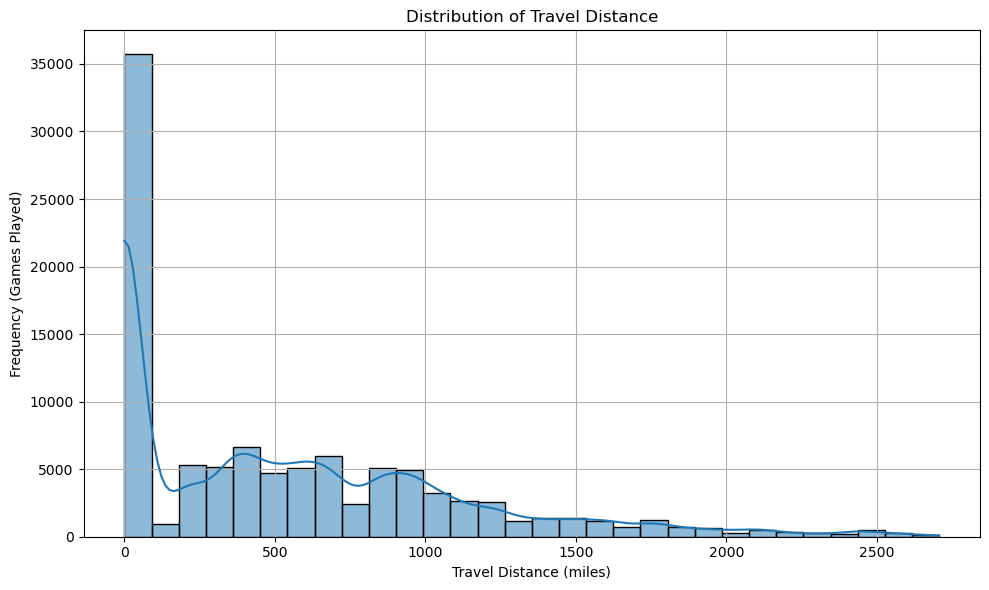

In [158]:
# Univariate Visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_analysis['Travel Distance'], bins=30, kde=True)
plt.title('Distribution of Travel Distance')
plt.xlabel('Travel Distance (miles)')
plt.ylabel('Frequency (Games Played)')
plt.grid(True)
plt.tight_layout()
plt.show()

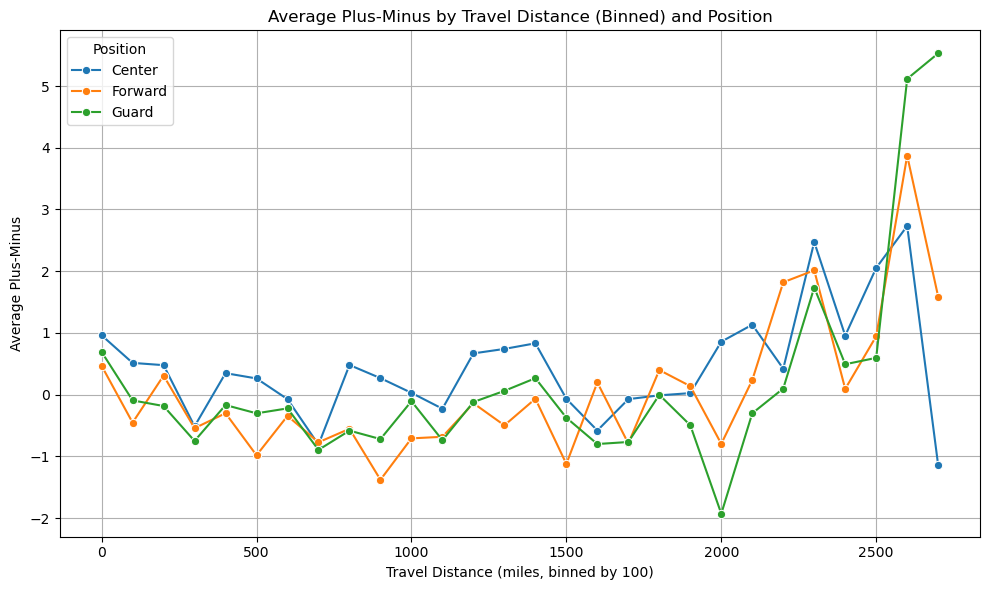

In [159]:
# Bin Travel Distance
df_analysis['Travel Bin'] = (df_analysis['Travel Distance'] // 100) * 100

# Grouping by Position and Bins
avg_plus_minus = df_analysis.groupby(['Position', 'Travel Bin'])['Plus Minus'].mean().reset_index()

# Bivariate Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_plus_minus, x='Travel Bin', y='Plus Minus', hue='Position', marker='o')
plt.title('Average Plus-Minus by Travel Distance (Binned) and Position')
plt.xlabel('Travel Distance (miles, binned by 100)')
plt.ylabel('Average Plus-Minus')
plt.grid(True)
plt.tight_layout()
plt.show()

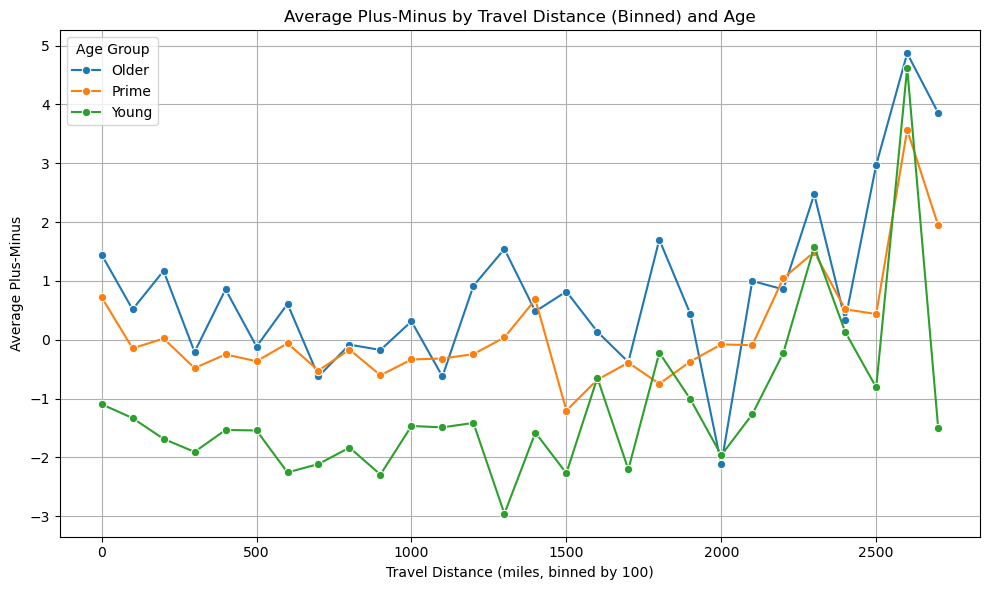

In [160]:
# Age Binning
def classify_age(age):
    if age < 25:
        return 'Young'
    elif age <= 30:
        return 'Prime'
    else:
        return 'Older'

df_analysis['Age Group'] = df_analysis['Age'].apply(classify_age)

# Group by Age Group Travel Distance
avg_plus_minus = df_analysis.groupby(['Age Group', 'Travel Bin'])['Plus Minus'].mean().reset_index()

# Bivariate Visualization pt.2
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_plus_minus, x='Travel Bin', y='Plus Minus', hue='Age Group', marker='o')
plt.title('Average Plus-Minus by Travel Distance (Binned) and Age')
plt.xlabel('Travel Distance (miles, binned by 100)')
plt.ylabel('Average Plus-Minus')
plt.grid(True)
plt.tight_layout()
plt.show()

In [162]:
# Extracting Plus-Minus for each group
plus_minus_center = df_analysis[df_analysis['Position'] == 'Center']['Plus Minus']
plus_minus_forward = df_analysis[df_analysis['Position'] == 'Forward']['Plus Minus']
plus_minus_guard = df_analysis[df_analysis['Position'] == 'Guard']['Plus Minus']

# ANOVA Test
f_stat, p_val = f_oneway(plus_minus_center, plus_minus_forward, plus_minus_guard)

print("ANOVA Test Results:")
print("Travel Distance impact on Plus Minus by Position")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

ANOVA Test Results:
Travel Distance impact on Plus Minus by Position
F-statistic: 13.494458726798173
P-value: 1.381054917686782e-06


In [163]:
# Extract Plus-Minus for each group
plus_minus_young = df_analysis[df_analysis['Age Group'] == 'Young']['Plus Minus']
plus_minus_prime = df_analysis[df_analysis['Age Group'] == 'Prime']['Plus Minus']
plus_minus_older = df_analysis[df_analysis['Age Group'] == 'Older']['Plus Minus']

# ANOVA Test
f_stat, p_val = f_oneway(plus_minus_young, plus_minus_prime, plus_minus_older)

print("ANOVA Test Results:")
print("Travel Distance impact on Plus Minus by Age Group")
print(f"F-statistic: {f_stat}")
print(f"P-value: {p_val}")

ANOVA Test Results:
Travel Distance impact on Plus Minus by Age Group
F-statistic: 232.1175984444726
P-value: 2.6466767814307368e-101


In [164]:
# XGBoost Regession Model
# Feature Selection
features = ['Travel Distance', 'Back-to-Back', 'Rest Days', 'Location']
target = 'Plus Minus'

# Data Preprocessing
X = df_analysis[features]
y = df_analysis[target]

X = pd.get_dummies(X, drop_first=True)

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

C:\Users\evhai\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


XGBoost Regressor - RMSE: 11.2778
XGBoost Regressor - R² Score: 0.0299


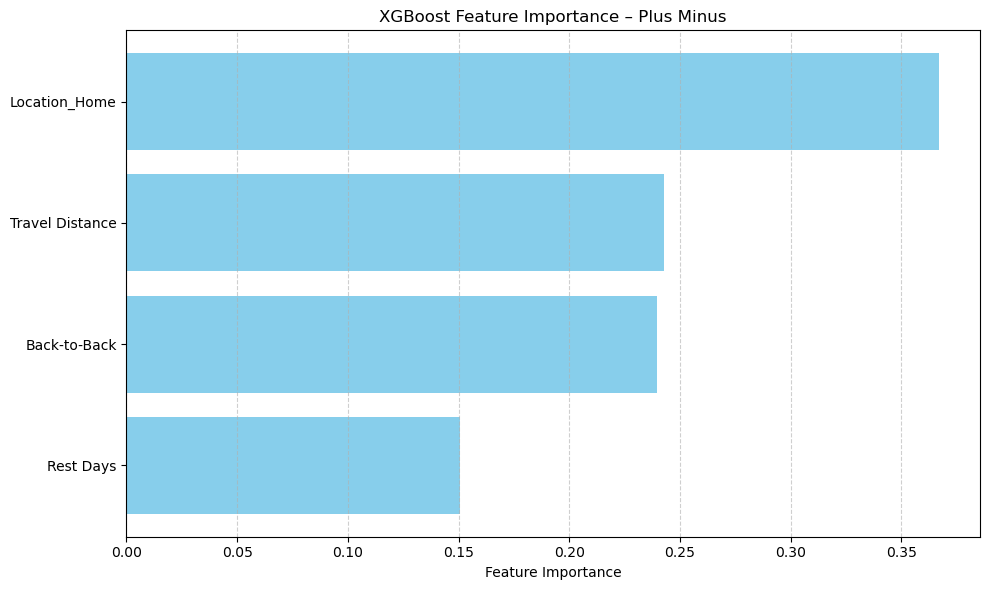

In [165]:
# Training XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

# Model Evaluation
xgb_rmse = mean_squared_error(y_test, y_pred_xgb, squared=False)
xgb_r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor - RMSE: {xgb_rmse:.4f}")
print(f"XGBoost Regressor - R² Score: {xgb_r2:.4f}")

# Displaying feature importance
importances = xgb_model.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[sorted_idx], align='center', color='skyblue')
plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance – Plus Minus")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()